In [1]:
import requests, json
import pandas as pd
import numpy as np
%matplotlib inline
SESSION = requests.Session()
f = open("bs_node_ip.txt","r")
RPC_HOST = f.readline()
RPC_HOST = str.replace(RPC_HOST,'\n','')
RPC_PORT = '8545'
RPC_URL = 'http://'+RPC_HOST+':'+RPC_PORT
pd.set_option('max_colwidth', 70)

## Basic JSON downloading

In [2]:
def getJSON(url, d=None):
    h = {"Content-Type": "application/json"}
    if d is None:
        r = SESSION.get(url, headers=h)
    else:
        r = SESSION.post(url, data=d, headers=h)
    json_data = r.text
    response = json.loads(json_data)
    return response

In [3]:
def getRawJSON(url, d=None):
    h = {"Content-Type": "application/json"}
    if d is None:
        r = SESSION.get(url, headers=h)
    else:
        r = SESSION.post(url, data=d, headers=h)
    json_data = r.text
    return json_data

In [4]:
# test if the getJSON function supports GET requests
# getJSON('https://api.etherscan.io/api?module=account&action=balance&address=0xde0b295669a9fd93d5f28d9ec85e40f4cb697bae&tag=latest&apikey=YourApiKeyToken')

In [5]:
# test if the getJSON function supports POST requests
# getJSON(RPC_URL,'{"jsonrpc":"2.0","method":"eth_syncing","params":[],"id":1}')

## Consensys EthJsonRpc Package

I wasn't able to quickly make the package work on Python 3

In [6]:
# from ethjsonrpc import EthJsonRpc
# c = EthJsonRpc('35.196.250.157', 8545)
# print(c.net_version())
# print(c.web3_clientVersion())
# print(c.eth_gasPrice())

So I began copying their functions. Most of them still need testing. Ideally we should fork and make our own package compatible with Python 3

In [7]:
# FROM https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/utils.py
def hex_to_dec(x):
    '''
    Convert hex to decimal
    '''
    return int(x, 16)

In [8]:
# FROM https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/utils.py
def clean_hex(d):
    '''
    Convert decimal to hex and remove the "L" suffix that is appended to large
    numbers
    '''
    return hex(d).rstrip('L')

In [9]:
# FROM https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/utils.py
def validate_block(block):
#     doesn't work on Python 3
#     if isinstance(block, basestring):
#         if block not in BLOCK_TAGS:
#             raise ValueError('invalid block tag')
    if isinstance(block, int):
        block = hex(block)
    return block

In [10]:
# FROM https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/utils.py
def wei_to_ether(wei):
    '''
    Convert wei to ether
    '''
    return 1.0 * wei / 10**18

In [11]:
# FROM https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/utils.py
def ether_to_wei(ether):
    '''
    Convert ether to wei
    '''
    return ether * 10**18

In [12]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/exceptions.py
class EthJsonRpcError(Exception):
    pass
class ConnectionError(EthJsonRpcError):
    pass
class BadStatusCodeError(EthJsonRpcError):
    pass
class BadJsonError(EthJsonRpcError):
    pass
class BadResponseError(EthJsonRpcError):
    pass

In [13]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
BLOCK_TAG_EARLIEST = 'earliest'
BLOCK_TAG_LATEST   = 'latest'
BLOCK_TAG_PENDING  = 'pending'
BLOCK_TAGS = (
    BLOCK_TAG_EARLIEST,
    BLOCK_TAG_LATEST,
    BLOCK_TAG_PENDING,
)

In [14]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def _call(method, params=None, _id=1):
    params = params or []
    data = {
        'jsonrpc': '2.0',
        'method':  method,
        'params':  params,
        'id':      _id,
    }
    scheme = 'http'
#     if tls:
#         scheme += 's'
    url = '{}://{}:{}'.format(scheme, RPC_HOST, RPC_PORT)
    headers = {'Content-Type': 'application/json'}
    try:
        r = SESSION.post(url, headers=headers, data=json.dumps(data))
    except RequestsConnectionError:
        raise ConnectionError
    if r.status_code / 100 != 2:
        raise BadStatusCodeError(r.status_code)
    try:
        response = r.json()
    except ValueError:
        raise BadJsonError(r.text)
    try:
        return response['result']
    except KeyError:
        raise BadResponseError(response)

In [15]:
################################################################################
# high-level methods
################################################################################

In [16]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def transfer(from_, to, amount):
    '''
    Send wei from one address to another
    '''
    return eth_sendTransaction(from_address=from_, to_address=to, value=amount)

In [17]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def create_contract(from_, code, gas, sig=None, args=None):
    '''
    Create a contract on the blockchain from compiled EVM code. Returns the
    transaction hash.
    '''
    from_ = from_ or eth_coinbase()
    if sig is not None and args is not None:
         types = sig[sig.find('(') + 1: sig.find(')')].split(',')
         encoded_params = encode_abi(types, args)
         code += encoded_params.encode('hex')
    return eth_sendTransaction(from_address=from_, gas=gas, data=code)

In [18]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def get_contract_address(tx):
    '''
    Get the address for a contract from the transaction that created it
    '''
    receipt = eth_getTransactionReceipt(tx)
    return receipt['contractAddress']

In [19]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def call(address, sig, args, result_types):
    '''
    Call a contract function on the RPC server, without sending a
    transaction (useful for reading data)
    '''
    data = _encode_function(sig, args)
    data_hex = data.encode('hex')
    response = eth_call(to_address=address, data=data_hex)
    return decode_abi(result_types, response[2:].decode('hex'))

In [20]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def call_with_transaction(from_, address, sig, args, gas=None, gas_price=None, value=None):
    '''
    Call a contract function by sending a transaction (useful for storing
    data)
    '''
    gas = gas or DEFAULT_GAS_PER_TX
    gas_price = gas_price or DEFAULT_GAS_PRICE
    data = _encode_function(sig, args)
    data_hex = data.encode('hex')
    return eth_sendTransaction(from_address=from_, to_address=address, data=data_hex, gas=gas,
                                    gas_price=gas_price, value=value)

In [21]:
################################################################################
# JSON-RPC methods
################################################################################

In [22]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def web3_clientVersion():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#web3_clientversion
    NEEDS TESTING
    '''
    return _call('web3_clientVersion')

In [23]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def web3_sha3(data):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#web3_sha3
    NEEDS TESTING
    '''
    data = str(data).encode('hex')
    return _call('web3_sha3', [data])

In [24]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def net_version():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#net_version
    NEEDS TESTING
    '''
    return _call('net_version')

In [25]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def net_listening():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#net_listening
    NEEDS TESTING
    '''
    return _call('net_listening')

In [26]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def net_peerCount():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#net_peercount
    NEEDS TESTING
    '''
    return hex_to_dec(_call('net_peerCount'))

In [27]:
def eth_protocolVersion():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_protocolversion
    NEEDS TESTING
    '''
    return _call('eth_protocolVersion')

In [28]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_syncing():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_syncing
    TESTED - MARKUS 2018-02-07
    '''
    return _call('eth_syncing')

In [29]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_coinbase():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_coinbase
    NEEDS TESTING
    '''
    return _call('eth_coinbase')

In [30]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_mining():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_mining
    NEEDS TESTING
    '''
    return _call('eth_mining')

In [31]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_hashrate():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_hashrate
    NEEDS TESTING
    '''
    return hex_to_dec(_call('eth_hashrate'))

In [32]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_gasPrice():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_gasprice
    NEEDS TESTING
    '''
    return hex_to_dec(_call('eth_gasPrice'))

In [33]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_accounts():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_accounts
    NEEDS TESTING
    '''
    return _call('eth_accounts')

In [34]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_blockNumber():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_blocknumber
    TESTED - MARKUS 2018-02-07
    '''
    return hex_to_dec(_call('eth_blockNumber'))

In [35]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getBalance(address=None, block=BLOCK_TAG_LATEST):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getbalance
    TESTED - MARKUS 2018-02-07
    '''
    address = address or eth_coinbase()
    block = validate_block(block)
    return hex_to_dec(_call('eth_getBalance', [address, block]))

In [36]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getStorageAt(address=None, position=0, block=BLOCK_TAG_LATEST):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getstorageat
    NEEDS TESTING
    '''
    block = validate_block(block)
    return _call('eth_getStorageAt', [address, hex(position), block])

In [37]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getTransactionCount(address, block=BLOCK_TAG_LATEST):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_gettransactioncount
    TESTED - MARKUS 2018-02-07
    '''
    block = validate_block(block)
    return hex_to_dec(_call('eth_getTransactionCount', [address, block]))

In [38]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getBlockTransactionCountByHash(block_hash):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getblocktransactioncountbyhash
    NEEDS TESTING
    '''
    return hex_to_dec(_call('eth_getBlockTransactionCountByHash', [block_hash]))

In [39]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getBlockTransactionCountByNumber(block=BLOCK_TAG_LATEST):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getblocktransactioncountbynumber
    NEEDS TESTING
    '''
    block = validate_block(block)
    return hex_to_dec(_call('eth_getBlockTransactionCountByNumber', [block]))

In [40]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getUncleCountByBlockHash(block_hash):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getunclecountbyblockhash
    NEEDS TESTING
    '''
    return hex_to_dec(_call('eth_getUncleCountByBlockHash', [block_hash]))

In [41]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getUncleCountByBlockNumber(block=BLOCK_TAG_LATEST):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getunclecountbyblocknumber
    NEEDS TESTING
    '''
    block = validate_block(block)
    return hex_to_dec(_call('eth_getUncleCountByBlockNumber', [block]))

In [42]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getCode(address, default_block=BLOCK_TAG_LATEST):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getcode
    NEEDS TESTING
    '''
#     doesn't work on Python 3
#     if isinstance(default_block, basestring):
#         if default_block not in BLOCK_TAGS:
#             raise ValueError
    return _call('eth_getCode', [address, default_block])

In [43]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_sign(address, data):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_sign
    NEEDS TESTING
    '''
    return _call('eth_sign', [address, data])

In [44]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_sendTransaction(to_address=None, from_address=None, gas=None, gas_price=None, value=None, data=None,
                        nonce=None):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_sendtransaction
    NEEDS TESTING
    '''
    params = {}
    params['from'] = from_address or eth_coinbase()
    if to_address is not None:
        params['to'] = to_address
    if gas is not None:
        params['gas'] = hex(gas)
    if gas_price is not None:
        params['gasPrice'] = clean_hex(gas_price)
    if value is not None:
        params['value'] = clean_hex(value)
    if data is not None:
        params['data'] = data
    if nonce is not None:
        params['nonce'] = hex(nonce)
    return _call('eth_sendTransaction', [params])

In [45]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_sendRawTransaction(data):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_sendrawtransaction
    NEEDS TESTING
    '''
    return _call('eth_sendRawTransaction', [data])

In [46]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_call(to_address, from_address=None, gas=None, gas_price=None, value=None, data=None,
             default_block=BLOCK_TAG_LATEST):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_call
    NEEDS TESTING
    '''
#     doesn't work on Python 3
#     if isinstance(default_block, basestring):
#         if default_block not in BLOCK_TAGS:
#             raise ValueError
    obj = {}
    obj['to'] = to_address
    if from_address is not None:
        obj['from'] = from_address
    if gas is not None:
        obj['gas'] = hex(gas)
    if gas_price is not None:
        obj['gasPrice'] = clean_hex(gas_price)
    if value is not None:
        obj['value'] = value
    if data is not None:
        obj['data'] = data
    return _call('eth_call', [obj, default_block])

In [47]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_estimateGas(to_address=None, from_address=None, gas=None, gas_price=None, value=None, data=None,
                    default_block=BLOCK_TAG_LATEST):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_estimategas
    NEEDS TESTING
    '''
#     doesn't work on Python 3
#     if isinstance(default_block, basestring):
#         if default_block not in BLOCK_TAGS:
#             raise ValueError
    obj = {}
    if to_address is not None:
        obj['to'] = to_address
    if from_address is not None:
        obj['from'] = from_address
    if gas is not None:
        obj['gas'] = hex(gas)
    if gas_price is not None:
        obj['gasPrice'] = clean_hex(gas_price)
    if value is not None:
        obj['value'] = value
    if data is not None:
        obj['data'] = data
    return hex_to_dec(_call('eth_estimateGas', [obj, default_block]))

In [48]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getBlockByHash(block_hash, tx_objects=True):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getblockbyhash
    NEEDS TESTING
    '''
    return _call('eth_getBlockByHash', [block_hash, tx_objects])

In [49]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getBlockByNumber(block=BLOCK_TAG_LATEST, tx_objects=True):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getblockbynumber
    NEEDS TESTING
    '''
    block = validate_block(block)
    return _call('eth_getBlockByNumber', [block, tx_objects])

In [50]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getTransactionByHash(tx_hash):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_gettransactionbyhash
    NEEDS TESTING
    '''
    return _call('eth_getTransactionByHash', [tx_hash])

In [51]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getTransactionByBlockHashAndIndex(block_hash, index=0):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_gettransactionbyblockhashandindex
    NEEDS TESTING
    '''
    return _call('eth_getTransactionByBlockHashAndIndex', [block_hash, hex(index)])

In [52]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getTransactionByBlockNumberAndIndex(block=BLOCK_TAG_LATEST, index=0):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_gettransactionbyblocknumberandindex
    NEEDS TESTING
    '''
    block = validate_block(block)
    return _call('eth_getTransactionByBlockNumberAndIndex', [block, hex(index)])

In [53]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getTransactionReceipt(tx_hash):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_gettransactionreceipt
    NEEDS TESTING
    '''
    return _call('eth_getTransactionReceipt', [tx_hash])

In [54]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getUncleByBlockHashAndIndex(block_hash, index=0):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getunclebyblockhashandindex
    NEEDS TESTING
    '''
    return _call('eth_getUncleByBlockHashAndIndex', [block_hash, hex(index)])

In [55]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getUncleByBlockNumberAndIndex(block=BLOCK_TAG_LATEST, index=0):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getunclebyblocknumberandindex
    NEEDS TESTING
    '''
    block = validate_block(block)
    return _call('eth_getUncleByBlockNumberAndIndex', [block, hex(index)])

In [56]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getCompilers():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getcompilers
    NEEDS TESTING
    '''
    return _call('eth_getCompilers')

In [57]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_compileSolidity(code):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_compilesolidity
    NEEDS TESTING
    '''
    return _call('eth_compileSolidity', [code])

In [58]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_compileLLL(code):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_compilelll
    N/A
    '''
    return _call('eth_compileLLL', [code])

In [59]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_compileSerpent(code):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_compileserpent
    N/A
    '''
    return _call('eth_compileSerpent', [code])

In [60]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_newFilter(from_block=BLOCK_TAG_LATEST, to_block=BLOCK_TAG_LATEST, address=None, topics=None):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_newfilter
    NEEDS TESTING
    '''
    _filter = {
        'fromBlock': from_block,
        'toBlock':   to_block,
        'address':   address,
        'topics':    topics,
    }
    return _call('eth_newFilter', [_filter])

In [61]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_newBlockFilter():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_newblockfilter
    NEEDS TESTING
    '''
    return _call('eth_newBlockFilter')

In [62]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_newPendingTransactionFilter():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_newpendingtransactionfilter
    NEEDS TESTING
    '''
    return hex_to_dec(_call('eth_newPendingTransactionFilter'))

In [63]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_uninstallFilter(filter_id):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_uninstallfilter
    NEEDS TESTING
    '''
    return _call('eth_uninstallFilter', [filter_id])

In [64]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getFilterChanges(filter_id):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getfilterchanges
    NEEDS TESTING
    '''
    return _call('eth_getFilterChanges', [filter_id])

In [65]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getFilterLogs(filter_id):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getfilterlogs
    NEEDS TESTING
    '''
    return _call('eth_getFilterLogs', [filter_id])

In [66]:
#FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
#def eth_getLogs(filter_object):
#    return _call('eth_getLogs', [filter_object])

# redefined by Markus 2018-02-08
def eth_getLogs(from_block=BLOCK_TAG_LATEST, to_block=BLOCK_TAG_LATEST, address=None, topics=None):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getlogs
    TESTED - MARKUS 2018-02-08
    '''
    _filter = {
        'fromBlock': from_block,
        'toBlock':   to_block,
        'address':   address,
        'topics':    topics,
    }
    return _call('eth_getLogs', [_filter])

In [67]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getWork():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getwork
    NEEDS TESTING
    '''
    return _call('eth_getWork')

In [68]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_submitWork(nonce, header, mix_digest):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_submitwork
    NEEDS TESTING
    '''
    return _call('eth_submitWork', [nonce, header, mix_digest])

In [69]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_submitHashrate(hash_rate, client_id):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_submithashrate
    NEEDS TESTING
    '''
    return _call('eth_submitHashrate', [hex(hash_rate), client_id])

In [70]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def shh_version():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#shh_version
    N/A
    '''
    return _call('shh_version')

In [71]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def shh_post(topics, payload, priority, ttl, from_=None, to=None):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#shh_post
    NEEDS TESTING
    '''
    whisper_object = {
        'from':     from_,
        'to':       to,
        'topics':   topics,
        'payload':  payload,
        'priority': hex(priority),
        'ttl':      hex(ttl),
    }
    return _call('shh_post', [whisper_object])

In [72]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def shh_newIdentity():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#shh_newidentity
    N/A
    '''
    return _call('shh_newIdentity')

In [73]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def shh_hasIdentity(address):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#shh_hasidentity
    NEEDS TESTING
    '''
    return _call('shh_hasIdentity', [address])

In [74]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def shh_newGroup():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#shh_newgroup
    N/A
    '''
    return _call('shh_newGroup')

In [75]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def shh_addToGroup():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#shh_addtogroup
    NEEDS TESTING
    '''
    return _call('shh_addToGroup')

In [76]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def shh_newFilter(to, topics):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#shh_newfilter
    NEEDS TESTING
    '''
    _filter = {
        'to':     to,
        'topics': topics,
    }
    return _call('shh_newFilter', [_filter])

In [77]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def shh_uninstallFilter(filter_id):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#shh_uninstallfilter
    NEEDS TESTING
    '''
    return _call('shh_uninstallFilter', [filter_id])

In [78]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def shh_getFilterChanges(filter_id):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#shh_getfilterchanges
    NEEDS TESTING
    '''
    return _call('shh_getFilterChanges', [filter_id])

In [79]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def shh_getMessages(filter_id):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#shh_getmessages
    NEEDS TESTING
    '''
    return _call('shh_getMessages', [filter_id])    

# Crypto Kitties Explorer
Exploring CryptoKitties data using JSON RPC on the BlockScience geth node

In [80]:
# define the addresses of the relevant contracts
coreContract = '0x06012c8cf97bead5deae237070f9587f8e7a266d'
contracts = {
    coreContract : 'core',
    '0xc7af99fe5513eb6710e6d5f44f9989da40f27f26' : 'siringAuction',
    '0xb1690c08e213a35ed9bab7b318de14420fb57d8c' : 'saleAuction',
}

# relevant Events signatures
events_signatures = {
    'AuctionCreated' : 'AuctionCreated(uint256,uint256,uint256,uint256)', # AuctionCreated(uint256 tokenId, uint256 startingPrice, uint256 endingPrice, uint256 duration);
    'AuctionSuccessful' : 'AuctionSuccessful(uint256,uint256,address)', # AuctionSuccessful(uint256 tokenId, uint256 totalPrice, address winner);
    'AuctionCancelled' : 'AuctionCancelled(uint256)', # AuctionCancelled(uint256 tokenId);
    'Pause' : 'Pause()',
    'Unpause' : 'Unpause()',
    'Transfer' : 'Transfer(address,address,uint256)', # Transfer(address from, address to, uint256 tokenId);
    'Approval' : 'Approval(address,address,uint256)', # Approval(address owner, address approved, uint256 tokenId);
    'ContractUpgrade' : 'ContractUpgrade(address)',
    'Birth' : 'Birth(address,uint256,uint256,uint256,uint256)', # Birth(address owner, uint256 kittyId, uint256 matronId, uint256 sireId, uint256 genes);
    'Pregnant' : 'Pregnant(address,uint256,uint256,uint256)' # Pregnant(address owner, uint256 matronId, uint256 sireId, uint256 cooldownEndBlock);
}

from Crypto.Hash import keccak
def keccak256(string):
    return keccak.new(digest_bits=256, data=bytes(string, 'utf-8')).hexdigest()

events_hashes = {'0x'+keccak256(v): k for k, v in events_signatures.items()}

In [81]:
for event in events_signatures:
    print(event + ': ' + keccak256(events_signatures[event]))

AuctionCreated: a9c8dfcda5664a5a124c713e386da27de87432d5b668e79458501eb296389ba7
AuctionSuccessful: 4fcc30d90a842164dd58501ab874a101a3749c3d4747139cefe7c876f4ccebd2
AuctionCancelled: 2809c7e17bf978fbc7194c0a694b638c4215e9140cacc6c38ca36010b45697df
Pause: 6985a02210a168e66602d3235cb6db0e70f92b3ba4d376a33c0f3d9434bff625
Unpause: 7805862f689e2f13df9f062ff482ad3ad112aca9e0847911ed832e158c525b33
Transfer: ddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef
Approval: 8c5be1e5ebec7d5bd14f71427d1e84f3dd0314c0f7b2291e5b200ac8c7c3b925
ContractUpgrade: 450db8da6efbe9c22f2347f7c2021231df1fc58d3ae9a2fa75d39fa446199305
Birth: 0a5311bd2a6608f08a180df2ee7c5946819a649b204b554bb8e39825b2c50ad5
Pregnant: 241ea03ca20251805084d27d4440371c34a0b85ff108f6bb5611248f73818b80


In [82]:
def getEvents(_address, _from_block, _to_block):
    json = eth_getLogs(from_block=_from_block, 
                       to_block=_to_block,
                       address=_address)
    df = pd.DataFrame.from_dict(json)
    df['contract'] = df['address'].apply(lambda x: contracts[x])
    df['event'] = df['topics'].apply(lambda x: events_hashes[x[0]])
    return df

from_block = hex(eth_blockNumber() - 10000)
to_block = hex(eth_blockNumber())

events = None

for c in contracts:
    if events is None:
        events = getEvents(c, from_block, to_block)
    else:
        e = getEvents(c, from_block, to_block)
        events = events.append(e, ignore_index=True)
events.head()

,address,blockHash,blockNumber,data,logIndex,removed,topics,transactionHash,transactionIndex,contract,event
0,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x8dfe62240ffe991106b3c9254be693920cf0a98717f30e829b5a69a712edd68c,0x4e9d90,0x0000000000000000000000007866a4e8c7309414d65665d0d4b9a4e4324333e3...,0xd,False,[0x0a5311bd2a6608f08a180df2ee7c5946819a649b204b554bb8e39825b2c50ad5],0x6abc53518e14cb8ab71cc464b8b93c819abeebb5c11c44727592edfdca660a13,0xf,core,Birth
1,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x8dfe62240ffe991106b3c9254be693920cf0a98717f30e829b5a69a712edd68c,0x4e9d90,0x0000000000000000000000000000000000000000000000000000000000000000...,0xe,False,[0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef],0x6abc53518e14cb8ab71cc464b8b93c819abeebb5c11c44727592edfdca660a13,0xf,core,Transfer
2,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x8dfe62240ffe991106b3c9254be693920cf0a98717f30e829b5a69a712edd68c,0x4e9d90,0x000000000000000000000000a110546519b9c6dfcebb58cd6a46859ac10abef0...,0x3a,False,[0x241ea03ca20251805084d27d4440371c34a0b85ff108f6bb5611248f73818b80],0x7f0c0b2a7c53eb9b183c98e913b3c8f0c9ac8ad3a6a5681053f36ccd6954cdd9,0x3f,core,Pregnant
3,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x8dfe62240ffe991106b3c9254be693920cf0a98717f30e829b5a69a712edd68c,0x4e9d90,0x00000000000000000000000028527fdd12fc78eba71fb989f546fd077c152293...,0x3b,False,[0x241ea03ca20251805084d27d4440371c34a0b85ff108f6bb5611248f73818b80],0x8063ca759841f0980d043e14a5d90ac920913fb33934faa0ca642e23b1e51251,0x41,core,Pregnant
4,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x8dfe62240ffe991106b3c9254be693920cf0a98717f30e829b5a69a712edd68c,0x4e9d90,0x000000000000000000000000b1690c08e213a35ed9bab7b318de14420fb57d8c...,0x64,False,[0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef],0xe887638f16b1a52a193a41936fabbca2b1caa7ef4c388d5c9ce52630afe20b08,0x7c,core,Transfer


In [83]:
events[['contract','event']].drop_duplicates()

,contract,event
0,core,Birth
1,core,Transfer
2,core,Pregnant
13639,core,Approval
43039,siringAuction,AuctionCreated
43040,siringAuction,AuctionSuccessful
43041,siringAuction,AuctionCancelled
45585,saleAuction,AuctionSuccessful
45586,saleAuction,AuctionCreated
45593,saleAuction,AuctionCancelled


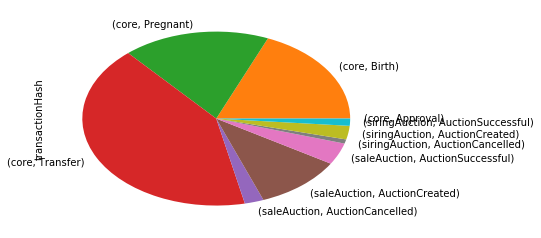

In [84]:
events.groupby(['contract','event']).transactionHash.count().plot(kind='pie')

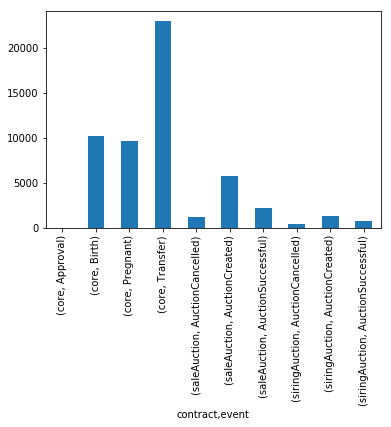

In [85]:
events.groupby(['contract','event']).transactionHash.count().plot(kind='bar')

In [86]:
events.sort_values(['blockNumber', 'transactionIndex', 'logIndex']).head(20)

,address,blockHash,blockNumber,data,logIndex,removed,topics,transactionHash,transactionIndex,contract,event
2,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x8dfe62240ffe991106b3c9254be693920cf0a98717f30e829b5a69a712edd68c,0x4e9d90,0x000000000000000000000000a110546519b9c6dfcebb58cd6a46859ac10abef0...,0x3a,False,[0x241ea03ca20251805084d27d4440371c34a0b85ff108f6bb5611248f73818b80],0x7f0c0b2a7c53eb9b183c98e913b3c8f0c9ac8ad3a6a5681053f36ccd6954cdd9,0x3f,core,Pregnant
3,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x8dfe62240ffe991106b3c9254be693920cf0a98717f30e829b5a69a712edd68c,0x4e9d90,0x00000000000000000000000028527fdd12fc78eba71fb989f546fd077c152293...,0x3b,False,[0x241ea03ca20251805084d27d4440371c34a0b85ff108f6bb5611248f73818b80],0x8063ca759841f0980d043e14a5d90ac920913fb33934faa0ca642e23b1e51251,0x41,core,Pregnant
45585,0xb1690c08e213a35ed9bab7b318de14420fb57d8c,0x8dfe62240ffe991106b3c9254be693920cf0a98717f30e829b5a69a712edd68c,0x4e9d90,0x0000000000000000000000000000000000000000000000000000000000083e33...,0x63,False,[0x4fcc30d90a842164dd58501ab874a101a3749c3d4747139cefe7c876f4ccebd2],0xe887638f16b1a52a193a41936fabbca2b1caa7ef4c388d5c9ce52630afe20b08,0x7c,saleAuction,AuctionSuccessful
4,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x8dfe62240ffe991106b3c9254be693920cf0a98717f30e829b5a69a712edd68c,0x4e9d90,0x000000000000000000000000b1690c08e213a35ed9bab7b318de14420fb57d8c...,0x64,False,[0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef],0xe887638f16b1a52a193a41936fabbca2b1caa7ef4c388d5c9ce52630afe20b08,0x7c,core,Transfer
0,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x8dfe62240ffe991106b3c9254be693920cf0a98717f30e829b5a69a712edd68c,0x4e9d90,0x0000000000000000000000007866a4e8c7309414d65665d0d4b9a4e4324333e3...,0xd,False,[0x0a5311bd2a6608f08a180df2ee7c5946819a649b204b554bb8e39825b2c50ad5],0x6abc53518e14cb8ab71cc464b8b93c819abeebb5c11c44727592edfdca660a13,0xf,core,Birth
1,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x8dfe62240ffe991106b3c9254be693920cf0a98717f30e829b5a69a712edd68c,0x4e9d90,0x0000000000000000000000000000000000000000000000000000000000000000...,0xe,False,[0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef],0x6abc53518e14cb8ab71cc464b8b93c819abeebb5c11c44727592edfdca660a13,0xf,core,Transfer
5,0x06012c8cf97bead5deae237070f9587f8e7a266d,0xe4fb997491235d6e1845c0ff1dddcea222403b240831e33528757299b75889ef,0x4e9d93,0x000000000000000000000000619a19246f238811ea21875e0fca1f3f1e0c8497...,0x2e,False,[0x241ea03ca20251805084d27d4440371c34a0b85ff108f6bb5611248f73818b80],0x2518198cd8f15a6bbe2c13e67ce768e2063718d7c2321d6b9cb45170087cd688,0x6a,core,Pregnant
6,0x06012c8cf97bead5deae237070f9587f8e7a266d,0xe4fb997491235d6e1845c0ff1dddcea222403b240831e33528757299b75889ef,0x4e9d93,0x00000000000000000000000017d0e82ebdef0516e196d71a1d5f1b7acadafba3...,0x6e,False,[0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef],0xa473322bcd3ba1a6def23f1ef261116f233c76edba2a9195ea99022996286f62,0xaa,core,Transfer
45586,0xb1690c08e213a35ed9bab7b318de14420fb57d8c,0xe4fb997491235d6e1845c0ff1dddcea222403b240831e33528757299b75889ef,0x4e9d93,0x000000000000000000000000000000000000000000000000000000000007009b...,0x6f,False,[0xa9c8dfcda5664a5a124c713e386da27de87432d5b668e79458501eb296389ba7],0xa473322bcd3ba1a6def23f1ef261116f233c76edba2a9195ea99022996286f62,0xaa,saleAuction,AuctionCreated
7,0x06012c8cf97bead5deae237070f9587f8e7a266d,0xe4fb997491235d6e1845c0ff1dddcea222403b240831e33528757299b75889ef,0x4e9d93,0x00000000000000000000000083dca1463395be54649ad9a6f0a571ebbbde10ab...,0x76,False,[0x241ea03ca20251805084d27d4440371c34a0b85ff108f6bb5611248f73818b80],0x5108d86b203c0b653e9a48d09fa0393e8dd4b0f082645365ec6316d6d28cdd26,0xb0,core,Pregnant


## Strange transactions: lots of births and transfers

0xdc3d978d88daa791b8e898ae74cd95a7bb5a38cab4555aac3c6da59dc09d62e0
0x58a5d848c63a0ced69c671eff4d6decb01ae57bfa8dd315ac1a758e5aa192e6e
0x5d91e6170d1cb8bf9642e4d319b87bd824b17ec52cd6b3d9a14f3f8f83e90b75

Looks like smart contracts (0xF8Fb76B05fd854cc6f35d5088B9D241CbbF616C3, 0xD18785571AE7F3b100e5B8788E3827120282f170) that call giveBirth on all pregnant kitties whose gestation period has passed

### Who is calling giveBirth?

In [87]:
births = events[events['event'] == 'Birth']
births.head()

,address,blockHash,blockNumber,data,logIndex,removed,topics,transactionHash,transactionIndex,contract,event
0,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x8dfe62240ffe991106b3c9254be693920cf0a98717f30e829b5a69a712edd68c,0x4e9d90,0x0000000000000000000000007866a4e8c7309414d65665d0d4b9a4e4324333e3...,0xd,False,[0x0a5311bd2a6608f08a180df2ee7c5946819a649b204b554bb8e39825b2c50ad5],0x6abc53518e14cb8ab71cc464b8b93c819abeebb5c11c44727592edfdca660a13,0xf,core,Birth
18,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x415d61345ed10f55490f007fa24ee523815c94bab1ad162d0e6774963e9feaaa,0x4e9d95,0x0000000000000000000000008abda881c2009f4de8688de9fdb7c03d5681df47...,0x13,False,[0x0a5311bd2a6608f08a180df2ee7c5946819a649b204b554bb8e39825b2c50ad5],0x5cd3d5df1007d6d8de2694b90bf1a56b49bfe071f88b1621c37699d03dab317e,0x2b,core,Birth
20,0x06012c8cf97bead5deae237070f9587f8e7a266d,0xdfb86c8d6581019d5d33570d33fe32384996b5cae2a9394afec5b5607de76493,0x4e9d96,0x000000000000000000000000ae41f73635b6f5f9556cd3b0d3970ada5fb0c1b5...,0x8,False,[0x0a5311bd2a6608f08a180df2ee7c5946819a649b204b554bb8e39825b2c50ad5],0x9925c2cd3c42ed218e280b68cbc2b9e4f28cc6c6f3a74ae62452e7a9644505a5,0x15,core,Birth
31,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x36918bed18c7b9e77d8c2bcc17a002764447cba57beead0a839a798a410a45ca,0x4e9d97,0x0000000000000000000000000429c8d18b916dffa9d3ac0bc56d34d9014456ef...,0x9,False,[0x0a5311bd2a6608f08a180df2ee7c5946819a649b204b554bb8e39825b2c50ad5],0x84e1d6b39feda8123ebb3975bbdba7fb7d81c7d92210ed277fdac3d8771363b0,0x14,core,Birth
37,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x56bab89d8912795e26aec612f63af11beb8a31274774f2ced83f7cff74c22862,0x4e9d98,0x00000000000000000000000041b302849e7ea16332ce7ac887c88be19dc2d3c6...,0x6f,False,[0x0a5311bd2a6608f08a180df2ee7c5946819a649b204b554bb8e39825b2c50ad5],0x4ad2fdd625a6174df927a49ec110506f839fe25cf9ca53217b065b119d4c26c1,0x9b,core,Birth


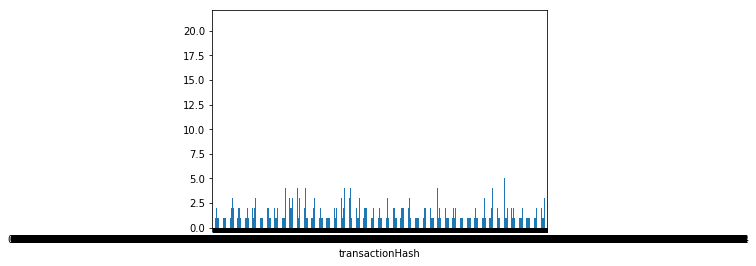

In [138]:
births.groupby(['transactionHash']).transactionHash.count().plot(kind='bar', xticks=[])

In [ ]:
births['caller'] = births['transactionHash'].apply(lambda x: eth_getTransactionByHash(x)['from'])
births['called'] = births['transactionHash'].apply(lambda x: eth_getTransactionByHash(x)['to'])

In [ ]:
births['gas'] = births['transactionHash'].apply(lambda x: int(eth_getTransactionByHash(x)['gas'],16))
births['gasPrice'] = births['transactionHash'].apply(lambda x: int(eth_getTransactionByHash(x)['gasPrice'],16))

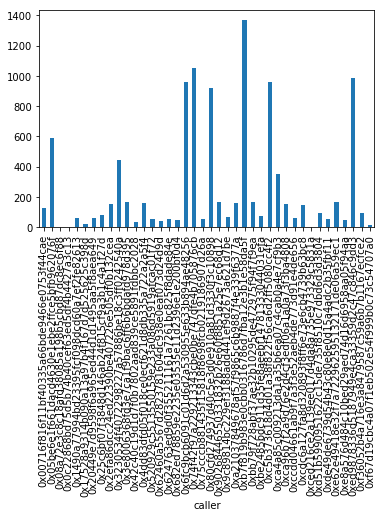

In [91]:
births.groupby(['caller']).data.count().plot(kind='bar')

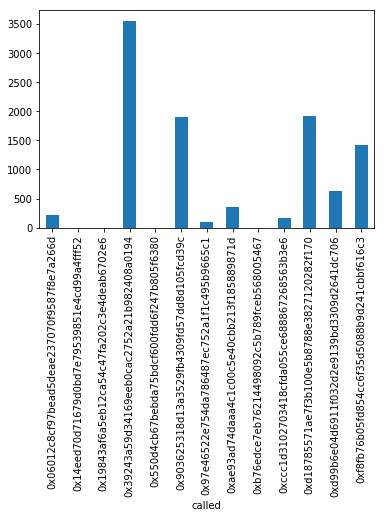

In [92]:
births.groupby(['called']).data.count().plot(kind='bar')

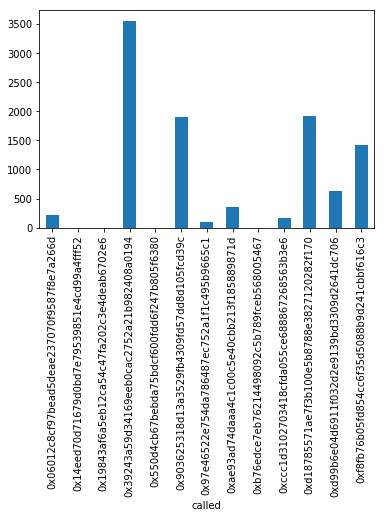

In [92]:
births.groupby(['called']).data.count().plot(kind='bar')

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


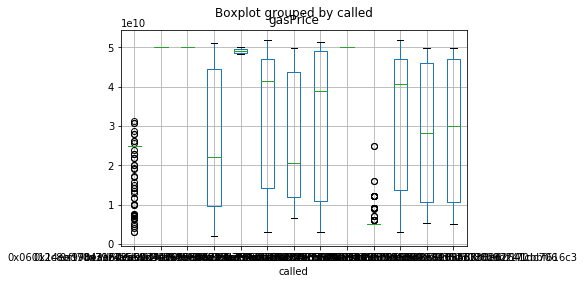

In [139]:
births.boxplot(column='gasPrice',by='called')

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


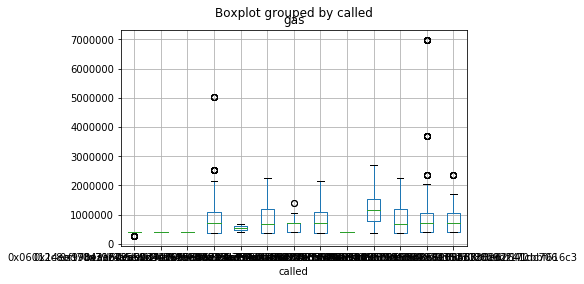

In [94]:
births.boxplot(column='gas',by='called')

In [95]:
births.called.unique()

array(['0x903625318d13a3529fb4309fd57dd8d105fcd39c',
       '0xd18785571ae7f3b100e5b8788e3827120282f170',
       '0x39243a59d34169eeb0cac2752a21b982408a0194',
       '0x06012c8cf97bead5deae237070f9587f8e7a266d',
       '0xae93ad74daaa4c1c00c5e40cbb213f185889871d',
       '0xd99b6e04d6911f032d2e9139bd3309d2641dc706',
       '0xccc1d3102703418cfda055ce688867268563b3e6',
       '0xf8fb76b05fd854cc6f35d5088b9d241cbbf616c3',
       '0x14eed70d71679d0bd7e79539851e4cd99a4fff52',
       '0x19843af6a5eb12ca54c47fa202c3e4deab6702e6',
       '0xb76edce7eb76214498092c5b789fceb568005467',
       '0x550d4cb67bebda75bdcf600fdd6f247b805f6380',
       '0x97e46522e754da786487ec752a1f1c495b9665c1'], dtype=object)

In [ ]:
births['matronId'] = births['data'].apply(lambda x: x[130:194])
births['matronId_dec'] = births['data'].apply(lambda x: int(x[130:194],16))
births['blockNumber_dec'] = births['blockNumber'].apply(lambda x: int(x,16))

In [141]:
births.head()

,address,blockHash,blockNumber,data,logIndex,removed,topics,transactionHash,transactionIndex,contract,event,caller,called,gas,gasPrice,matronId,matronId_dec,blockNumber_dec
0,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x8dfe62240ffe991106b3c9254be693920cf0a98717f30e829b5a69a712edd68c,0x4e9d90,0x0000000000000000000000007866a4e8c7309414d65665d0d4b9a4e4324333e3...,0xd,False,[0x0a5311bd2a6608f08a180df2ee7c5946819a649b204b554bb8e39825b2c50ad5],0x6abc53518e14cb8ab71cc464b8b93c819abeebb5c11c44727592edfdca660a13,0xf,core,Birth,0xc5b373618d4d01a38f822f56ca6d2ff5080cc4f2,0x903625318d13a3529fb4309fd57dd8d105fcd39c,360000,33588671923,00000000000000000000000000000000000000000000000000000000000814c3,529603,5152144
18,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x415d61345ed10f55490f007fa24ee523815c94bab1ad162d0e6774963e9feaaa,0x4e9d95,0x0000000000000000000000008abda881c2009f4de8688de9fdb7c03d5681df47...,0x13,False,[0x0a5311bd2a6608f08a180df2ee7c5946819a649b204b554bb8e39825b2c50ad5],0x5cd3d5df1007d6d8de2694b90bf1a56b49bfe071f88b1621c37699d03dab317e,0x2b,core,Birth,0xed9878336d5187949e4ca33359d2c47c846c9dd3,0x903625318d13a3529fb4309fd57dd8d105fcd39c,360000,33588671923,00000000000000000000000000000000000000000000000000000000000841e7,541159,5152149
20,0x06012c8cf97bead5deae237070f9587f8e7a266d,0xdfb86c8d6581019d5d33570d33fe32384996b5cae2a9394afec5b5607de76493,0x4e9d96,0x000000000000000000000000ae41f73635b6f5f9556cd3b0d3970ada5fb0c1b5...,0x8,False,[0x0a5311bd2a6608f08a180df2ee7c5946819a649b204b554bb8e39825b2c50ad5],0x9925c2cd3c42ed218e280b68cbc2b9e4f28cc6c6f3a74ae62452e7a9644505a5,0x15,core,Birth,0x80cfd274937d40c5e3d0e910a81d3330f3c10898,0xd18785571ae7f3b100e5b8788e3827120282f170,360000,20000000000,0000000000000000000000000000000000000000000000000000000000085d49,548169,5152150
31,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x36918bed18c7b9e77d8c2bcc17a002764447cba57beead0a839a798a410a45ca,0x4e9d97,0x0000000000000000000000000429c8d18b916dffa9d3ac0bc56d34d9014456ef...,0x9,False,[0x0a5311bd2a6608f08a180df2ee7c5946819a649b204b554bb8e39825b2c50ad5],0x84e1d6b39feda8123ebb3975bbdba7fb7d81c7d92210ed277fdac3d8771363b0,0x14,core,Birth,0xed9878336d5187949e4ca33359d2c47c846c9dd3,0xd18785571ae7f3b100e5b8788e3827120282f170,360000,33588671923,00000000000000000000000000000000000000000000000000000000000856c9,546505,5152151
37,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x56bab89d8912795e26aec612f63af11beb8a31274774f2ced83f7cff74c22862,0x4e9d98,0x00000000000000000000000041b302849e7ea16332ce7ac887c88be19dc2d3c6...,0x6f,False,[0x0a5311bd2a6608f08a180df2ee7c5946819a649b204b554bb8e39825b2c50ad5],0x4ad2fdd625a6174df927a49ec110506f839fe25cf9ca53217b065b119d4c26c1,0x9b,core,Birth,0x00716f816f11bf40335a66bde9466e0753f44cae,0x39243a59d34169eeb0cac2752a21b982408a0194,1080000,3100110000,0000000000000000000000000000000000000000000000000000000000084961,543073,5152152


## Most wanted genes
We can get the genetic sequence of the most recent breeds to try to see what the most wanted genes are

In [98]:
pregnancies = events[events['event'] == 'Pregnant']
pregnancies.head()

,address,blockHash,blockNumber,data,logIndex,removed,topics,transactionHash,transactionIndex,contract,event
2,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x8dfe62240ffe991106b3c9254be693920cf0a98717f30e829b5a69a712edd68c,0x4e9d90,0x000000000000000000000000a110546519b9c6dfcebb58cd6a46859ac10abef0...,0x3a,False,[0x241ea03ca20251805084d27d4440371c34a0b85ff108f6bb5611248f73818b80],0x7f0c0b2a7c53eb9b183c98e913b3c8f0c9ac8ad3a6a5681053f36ccd6954cdd9,0x3f,core,Pregnant
3,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x8dfe62240ffe991106b3c9254be693920cf0a98717f30e829b5a69a712edd68c,0x4e9d90,0x00000000000000000000000028527fdd12fc78eba71fb989f546fd077c152293...,0x3b,False,[0x241ea03ca20251805084d27d4440371c34a0b85ff108f6bb5611248f73818b80],0x8063ca759841f0980d043e14a5d90ac920913fb33934faa0ca642e23b1e51251,0x41,core,Pregnant
5,0x06012c8cf97bead5deae237070f9587f8e7a266d,0xe4fb997491235d6e1845c0ff1dddcea222403b240831e33528757299b75889ef,0x4e9d93,0x000000000000000000000000619a19246f238811ea21875e0fca1f3f1e0c8497...,0x2e,False,[0x241ea03ca20251805084d27d4440371c34a0b85ff108f6bb5611248f73818b80],0x2518198cd8f15a6bbe2c13e67ce768e2063718d7c2321d6b9cb45170087cd688,0x6a,core,Pregnant
7,0x06012c8cf97bead5deae237070f9587f8e7a266d,0xe4fb997491235d6e1845c0ff1dddcea222403b240831e33528757299b75889ef,0x4e9d93,0x00000000000000000000000083dca1463395be54649ad9a6f0a571ebbbde10ab...,0x76,False,[0x241ea03ca20251805084d27d4440371c34a0b85ff108f6bb5611248f73818b80],0x5108d86b203c0b653e9a48d09fa0393e8dd4b0f082645365ec6316d6d28cdd26,0xb0,core,Pregnant
8,0x06012c8cf97bead5deae237070f9587f8e7a266d,0xe4fb997491235d6e1845c0ff1dddcea222403b240831e33528757299b75889ef,0x4e9d93,0x00000000000000000000000098aec1e4e88564a48331e55b4366f6f4b2e48f24...,0x79,False,[0x241ea03ca20251805084d27d4440371c34a0b85ff108f6bb5611248f73818b80],0x6cef50a0cfb8235e5d46d1c6109f2729645d349bdae83db3eeaa645174444d74,0xb4,core,Pregnant


The data field of a Pregnant should be structured as such:
1. '0x'
1. '000000000000000000000000' - 24 zeros before the owner address
1. owner address (40 hex characters)
1. matronId (64 hex characters)
1. sireId (64 hex characters)
1. cooldownEndBlock (64 hex characters)

In [ ]:
pregnancies['owner'] = '0x' + pregnancies['data'].apply(lambda x: x[26:66])
pregnancies['matronId'] = pregnancies['data'].apply(lambda x: x[66:130])
pregnancies['sireId'] = pregnancies['data'].apply(lambda x: x[130:194])
pregnancies['matronId_dec'] = pregnancies['data'].apply(lambda x: int(x[66:130],16))
pregnancies['sireId_dec'] = pregnancies['data'].apply(lambda x: int(x[130:194],16))

In [140]:
pregnancies.head()

,address,blockHash,blockNumber,data,logIndex,removed,topics,transactionHash,transactionIndex,contract,event,owner,matronId,sireId,matronId_dec,sireId_dec,preg_endBlock,preg_endBlock_dec,matronGenes,sireGenes
2,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x8dfe62240ffe991106b3c9254be693920cf0a98717f30e829b5a69a712edd68c,0x4e9d90,0x000000000000000000000000a110546519b9c6dfcebb58cd6a46859ac10abef0...,0x3a,False,[0x241ea03ca20251805084d27d4440371c34a0b85ff108f6bb5611248f73818b80],0x7f0c0b2a7c53eb9b183c98e913b3c8f0c9ac8ad3a6a5681053f36ccd6954cdd9,0x3f,core,Pregnant,0xa110546519b9c6dfcebb58cd6a46859ac10abef0,000000000000000000000000000000000000000000000000000000000007e577,000000000000000000000000000000000000000000000000000000000007e4c9,517495,517321,00000000000000000000000000000000000000000000000000000000004ea150,5153104,0x000062589094a5718665a80f01c056008e2acb631d43184230a1624274c53da3,0x00005b18909c2649821701ca130071988e6bacb00cc31044641c65433487b963
3,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x8dfe62240ffe991106b3c9254be693920cf0a98717f30e829b5a69a712edd68c,0x4e9d90,0x00000000000000000000000028527fdd12fc78eba71fb989f546fd077c152293...,0x3b,False,[0x241ea03ca20251805084d27d4440371c34a0b85ff108f6bb5611248f73818b80],0x8063ca759841f0980d043e14a5d90ac920913fb33934faa0ca642e23b1e51251,0x41,core,Pregnant,0x28527fdd12fc78eba71fb989f546fd077c152293,0000000000000000000000000000000000000000000000000000000000073157,0000000000000000000000000000000000000000000000000000000000073e45,471383,474693,00000000000000000000000000000000000000000000000000000000004e9db8,5152184,0x00006210921492484697b9c819400218c46b18a20c23214c6084a1725296b1ad,0x00004a16b29cf3198214252e014a209863735c828546298e6388e262949085ad
5,0x06012c8cf97bead5deae237070f9587f8e7a266d,0xe4fb997491235d6e1845c0ff1dddcea222403b240831e33528757299b75889ef,0x4e9d93,0x000000000000000000000000619a19246f238811ea21875e0fca1f3f1e0c8497...,0x2e,False,[0x241ea03ca20251805084d27d4440371c34a0b85ff108f6bb5611248f73818b80],0x2518198cd8f15a6bbe2c13e67ce768e2063718d7c2321d6b9cb45170087cd688,0x6a,core,Pregnant,0x619a19246f238811ea21875e0fca1f3f1e0c8497,0000000000000000000000000000000000000000000000000000000000080d81,000000000000000000000000000000000000000000000000000000000000e70a,527745,59146,00000000000000000000000000000000000000000000000000000000004e9da7,5152167,0x000062d290988530d2e4b9c810cf171084319a452812304e63206763df40b82f,0x00006312821c851b8c35292a0140311c84331cc30020214e7114624a1e953529
7,0x06012c8cf97bead5deae237070f9587f8e7a266d,0xe4fb997491235d6e1845c0ff1dddcea222403b240831e33528757299b75889ef,0x4e9d93,0x00000000000000000000000083dca1463395be54649ad9a6f0a571ebbbde10ab...,0x76,False,[0x241ea03ca20251805084d27d4440371c34a0b85ff108f6bb5611248f73818b80],0x5108d86b203c0b653e9a48d09fa0393e8dd4b0f082645365ec6316d6d28cdd26,0xb0,core,Pregnant,0x83dca1463395be54649ad9a6f0a571ebbbde10ab,000000000000000000000000000000000000000000000000000000000004100c,0000000000000000000000000000000000000000000000000000000000069849,266252,432201,00000000000000000000000000000000000000000000000000000000004e9e0b,5152267,0x00005a189394b20a4c31a9292b18c210844358d0108338cc6304277398972dad,0x000062d8b3964571869a3d483818c310d04254a000d0288e708c514a9e96bdeb
8,0x06012c8cf97bead5deae237070f9587f8e7a266d,0xe4fb997491235d6e1845c0ff1dddcea222403b240831e33528757299b75889ef,0x4e9d93,0x00000000000000000000000098aec1e4e88564a48331e55b4366f6f4b2e48f24...,0x79,False,[0x241ea03ca20251805084d27d4440371c34a0b85ff108f6bb5611248f73818b80],0x6cef50a0cfb8235e5d46d1c6109f2729645d349bdae83db3eeaa645174444d74,0xb4,core,Pregnant,0x98aec1e4e88564a48331e55b4366f6f4b2e48f24,00000000000000000000000000000000000000000000000000000000000856ad,0000000000000000000000000000000000000000000000000000000000069b30,546477,432944,00000000000000000000000000000000000000000000000000000000004e9e0b,5152267,0x00004a1883908408d234a94a01400398c45994d2a8212cc6731c677310c539d6,0x00005b16821ca508dce401e9180e031026329861847038cb3198e74a98c73d76


In [ ]:
pregnancies['preg_endBlock'] = pregnancies['data'].apply(lambda x: x[194:258])
pregnancies['preg_endBlock_dec'] = pregnancies['data'].apply(lambda x: int(x[194:258],16))

In [ ]:
def getKittyGenes(kittyId):
    kitty = eth_call(to_address=coreContract, data='0xe98b7f4d'+kittyId)
    return kitty[-64:]

pregnancies['matronGenes'] = pregnancies['matronId'].apply(lambda x: '0x'+getKittyGenes(x))
pregnancies['sireGenes'] = pregnancies['sireId'].apply(lambda x: '0x'+getKittyGenes(x))

In [103]:
pregnancies.head()

,address,blockHash,blockNumber,data,logIndex,removed,topics,transactionHash,transactionIndex,contract,event,owner,matronId,sireId,matronId_dec,sireId_dec,preg_endBlock,preg_endBlock_dec,matronGenes,sireGenes
2,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x8dfe62240ffe991106b3c9254be693920cf0a98717f30e829b5a69a712edd68c,0x4e9d90,0x000000000000000000000000a110546519b9c6dfcebb58cd6a46859ac10abef0...,0x3a,False,[0x241ea03ca20251805084d27d4440371c34a0b85ff108f6bb5611248f73818b80],0x7f0c0b2a7c53eb9b183c98e913b3c8f0c9ac8ad3a6a5681053f36ccd6954cdd9,0x3f,core,Pregnant,0xa110546519b9c6dfcebb58cd6a46859ac10abef0,000000000000000000000000000000000000000000000000000000000007e577,000000000000000000000000000000000000000000000000000000000007e4c9,517495,517321,00000000000000000000000000000000000000000000000000000000004ea150,5153104,0x000062589094a5718665a80f01c056008e2acb631d43184230a1624274c53da3,0x00005b18909c2649821701ca130071988e6bacb00cc31044641c65433487b963
3,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x8dfe62240ffe991106b3c9254be693920cf0a98717f30e829b5a69a712edd68c,0x4e9d90,0x00000000000000000000000028527fdd12fc78eba71fb989f546fd077c152293...,0x3b,False,[0x241ea03ca20251805084d27d4440371c34a0b85ff108f6bb5611248f73818b80],0x8063ca759841f0980d043e14a5d90ac920913fb33934faa0ca642e23b1e51251,0x41,core,Pregnant,0x28527fdd12fc78eba71fb989f546fd077c152293,0000000000000000000000000000000000000000000000000000000000073157,0000000000000000000000000000000000000000000000000000000000073e45,471383,474693,00000000000000000000000000000000000000000000000000000000004e9db8,5152184,0x00006210921492484697b9c819400218c46b18a20c23214c6084a1725296b1ad,0x00004a16b29cf3198214252e014a209863735c828546298e6388e262949085ad
5,0x06012c8cf97bead5deae237070f9587f8e7a266d,0xe4fb997491235d6e1845c0ff1dddcea222403b240831e33528757299b75889ef,0x4e9d93,0x000000000000000000000000619a19246f238811ea21875e0fca1f3f1e0c8497...,0x2e,False,[0x241ea03ca20251805084d27d4440371c34a0b85ff108f6bb5611248f73818b80],0x2518198cd8f15a6bbe2c13e67ce768e2063718d7c2321d6b9cb45170087cd688,0x6a,core,Pregnant,0x619a19246f238811ea21875e0fca1f3f1e0c8497,0000000000000000000000000000000000000000000000000000000000080d81,000000000000000000000000000000000000000000000000000000000000e70a,527745,59146,00000000000000000000000000000000000000000000000000000000004e9da7,5152167,0x000062d290988530d2e4b9c810cf171084319a452812304e63206763df40b82f,0x00006312821c851b8c35292a0140311c84331cc30020214e7114624a1e953529
7,0x06012c8cf97bead5deae237070f9587f8e7a266d,0xe4fb997491235d6e1845c0ff1dddcea222403b240831e33528757299b75889ef,0x4e9d93,0x00000000000000000000000083dca1463395be54649ad9a6f0a571ebbbde10ab...,0x76,False,[0x241ea03ca20251805084d27d4440371c34a0b85ff108f6bb5611248f73818b80],0x5108d86b203c0b653e9a48d09fa0393e8dd4b0f082645365ec6316d6d28cdd26,0xb0,core,Pregnant,0x83dca1463395be54649ad9a6f0a571ebbbde10ab,000000000000000000000000000000000000000000000000000000000004100c,0000000000000000000000000000000000000000000000000000000000069849,266252,432201,00000000000000000000000000000000000000000000000000000000004e9e0b,5152267,0x00005a189394b20a4c31a9292b18c210844358d0108338cc6304277398972dad,0x000062d8b3964571869a3d483818c310d04254a000d0288e708c514a9e96bdeb
8,0x06012c8cf97bead5deae237070f9587f8e7a266d,0xe4fb997491235d6e1845c0ff1dddcea222403b240831e33528757299b75889ef,0x4e9d93,0x00000000000000000000000098aec1e4e88564a48331e55b4366f6f4b2e48f24...,0x79,False,[0x241ea03ca20251805084d27d4440371c34a0b85ff108f6bb5611248f73818b80],0x6cef50a0cfb8235e5d46d1c6109f2729645d349bdae83db3eeaa645174444d74,0xb4,core,Pregnant,0x98aec1e4e88564a48331e55b4366f6f4b2e48f24,00000000000000000000000000000000000000000000000000000000000856ad,0000000000000000000000000000000000000000000000000000000000069b30,546477,432944,00000000000000000000000000000000000000000000000000000000004e9e0b,5152267,0x00004a1883908408d234a94a01400398c45994d2a8212cc6731c677310c539d6,0x00005b16821ca508dce401e9180e031026329861847038cb3198e74a98c73d76


In [148]:
pregnancies.loc[2, 'matronGenes']

'0x000062589094a5718665a80f01c056008e2acb631d43184230a1624274c53da3'

In [149]:
pregnancies.loc[2, 'sireGenes']

'0x00005b18909c2649821701ca130071988e6bacb00cc31044641c65433487b963'

In [172]:
s = "{0:#0{1}b}".format(int(pregnancies.loc[2, 'sireGenes'],16),258)
b = "{0:#0{1}b}".format(int(pregnancies.loc[2, 'matronGenes'],16),258)

In [173]:
s

'0b0000000000000000010110110001100010010000100111000010011001001001100000100001011100000001110010100001001100000000011100011001100010001110011010111010110010110000000011001100001100010000010001000110010000011100011001010100001100110100100001111011100101100011'

In [174]:
b

'0b0000000000000000011000100101100010010000100101001010010101110001100001100110010110101000000011110000000111000000010101100000000010001110001010101100101101100011000111010100001100011000010000100011000010100001011000100100001001110100110001010011110110100011'